<a href="https://colab.research.google.com/github/bostankhan6/Image-Segmentation-Unet-DeepLabV3-Segnet/blob/master/Unet_inference_test_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download and unzip the Data Set
!gdown https://drive.google.com/uc?id=1AggikAVBoJUNPLnWktFgeb8bq2QJqLOE
!unzip -q patched_MonuSeg.zip

Downloading...
From: https://drive.google.com/uc?id=1AggikAVBoJUNPLnWktFgeb8bq2QJqLOE
To: /content/patched_MonuSeg.zip
232MB [00:03, 74.2MB/s]


In [2]:
%tensorflow_version 1.x
import os
import random
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook
from skimage.io import imshow
from skimage.transform import resize

import tensorflow as tf
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, GlobalAveragePooling2D, Multiply
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, load_img

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
"""
This function can be used to read the images from the dataset created by the patchify_dataset.py.
Example Usage:
X, y = get_images("ModMonuSeg/Training/", (im_width, im_height))
"""
def get_images(parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
  tissue_dir = parent_dir + img_folder
  gt_dir = parent_dir + gt_folder

  im_width, im_height = im_shape


  ids = next(os.walk(tissue_dir))[2]
  print("No. of images = ", len(ids))

  X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
  y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

  # tqdm is used to display the progress bar
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(tissue_dir+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 3), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0]
    mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
    if gt_extension:
      mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
    mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

  return X, y

In [4]:
# Load the test set
val_parent_dir = '/content/content/ACV-Assignment-3/patched_MonuSeg/Test/'

im_shape = (256,256)

X_test, y_test = get_images(val_parent_dir, im_shape, gt_extension='png')

No. of images =  504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
# Define metric functions
def dice_coef(y_true, y_pred):
  intersection = K.sum(y_true * y_pred, axis = (1,2,3))
  union = K.sum(y_true, axis = (1,2,3)) + K.sum(y_pred, axis = (1,2,3))
  return K.mean((2.0*intersection+1)/(union+1),axis = 0) 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
# Downlaod the Unet model
!gdown  https://drive.google.com/uc?id=1-_RERzXJ70OTZYlvE4YmHMyRMSTkGneF

Downloading...
From: https://drive.google.com/uc?id=1-_RERzXJ70OTZYlvE4YmHMyRMSTkGneF
To: /content/improved_unet_model.h5
15.7MB [00:00, 33.8MB/s]


In [7]:
 #Loading the best validation accuracy model and evaluating on test set
model = load_model('/content/improved_unet_model.h5',
                   custom_objects={"dice_coef": dice_coef,
                                   "f1_m": f1_m
                                   }
                   )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [8]:
# Evaluate on the test set
model.evaluate(X_test, y_test, verbose=1)

504/504 [==============================] - 11s 21ms/step


[0.3436149060726166,
 0.9140175580978394,
 0.7727589011192322,
 0.7888469099998474]

In [9]:
# Predict on train, val and test
preds_test = model.predict(X_test, batch_size = 1, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.float32)

504/504 [==============================] - 3s 6ms/step


In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
  #Arguments:
  #X: Train Set
  #y: ground truth Masks
  #preds: the predicted masks
  #binary_preds: the predicted masks after thresholding to 0 or 1
  #ix: if None, it will take a random sample. If provided with the index of the 
  #sample, it will plot that specific sample from tissue images
  
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X)-1)

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')
    
    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('Predicted');

    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted binary');

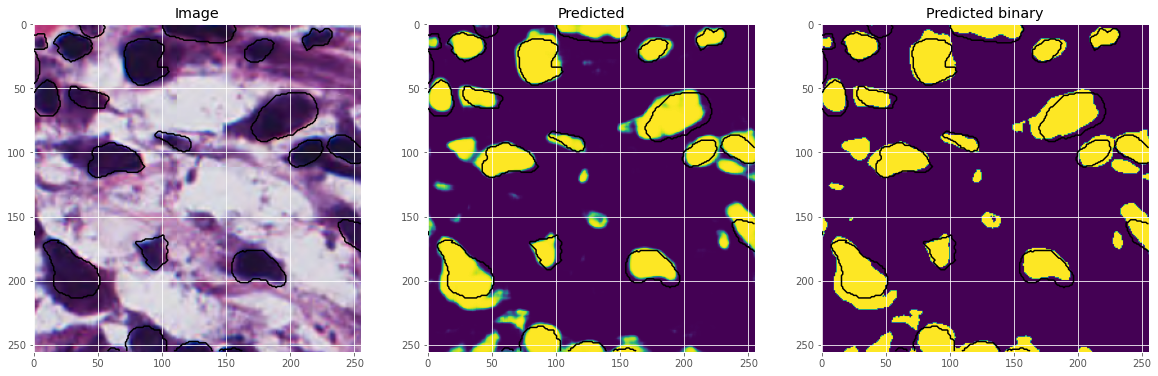

In [12]:
plot_sample(X_test, y_test, preds_test, preds_test_t)